In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show_image(title: str, img_bgr: np.ndarray):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12, 6))
    plt.title(title)
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.show()

def sift_ransac_homography(
    img1_bgr: np.ndarray,
    img2_bgr: np.ndarray,
    ratio_thresh: float = 0.75,
    ransac_reproj_thresh: float = 3.0,
    min_matches: int = 20
):
    # Convert to gray for SIFT
    img1_gray = cv2.cvtColor(img1_bgr, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2_bgr, cv2.COLOR_BGR2GRAY)

    # SIFT detect + compute
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1_gray, None)
    kp2, des2 = sift.detectAndCompute(img2_gray, None)

    if des1 is None or des2 is None:
        raise RuntimeError("No descriptors found in one of the images (des1 or des2 is None).")

    # KNN matching + Lowe ratio test
    matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    knn = matcher.knnMatch(des1, des2, k=2)

    good = []
    for m, n in knn:
        if m.distance < ratio_thresh * n.distance:
            good.append(m)

    if len(good) < min_matches:
        raise RuntimeError(f"Not enough good matches: {len(good)} < {min_matches}")

    pts1 = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    pts2 = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    # RANSAC homography
    H, inlier_mask = cv2.findHomography(pts1, pts2, cv2.RANSAC, ransac_reproj_thresh)
    if H is None or inlier_mask is None:
        raise RuntimeError("Homography estimation failed (H or inlier_mask is None).")

    inlier_mask = inlier_mask.ravel().astype(bool)
    inliers = [m for m, ok in zip(good, inlier_mask) if ok]
    outliers = [m for m, ok in zip(good, inlier_mask) if not ok]

    # Visualize matches: inliers green, outliers red (two images side by side)
    img_matches = cv2.drawMatches(
        img1_bgr, kp1, img2_bgr, kp2, inliers, None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    # Warp img1 onto img2 to visualize alignment
    h2, w2 = img2_bgr.shape[:2]
    warped1 = cv2.warpPerspective(img1_bgr, H, (w2, h2))
    overlay = cv2.addWeighted(img2_bgr, 0.5, warped1, 0.5, 0.0)

    result = {
        "kp1": kp1, "kp2": kp2,
        "good_matches": good,
        "inliers": inliers,
        "outliers": outliers,
        "H": H,
        "inlier_mask": inlier_mask,
        "img_matches": img_matches,
        "warped1": warped1,
        "overlay": overlay,
    }
    return result

# Example usage:
# img1_bgr = cv2.imread("frame_0001.png")
# img2_bgr = cv2.imread("frame_0002.png")
# res = sift_ransac_homography(img1_bgr, img2_bgr)
# show_image(f"Inlier matches: {len(res['inliers'])}/{len(res['good_matches'])}", res["img_matches"])
# show_image("Overlay (img2 + warped img1)", res["overlay"])


In [2]:
def estimate_pose_essential(
    img1_bgr: np.ndarray,
    img2_bgr: np.ndarray,
    K: np.ndarray,
    ratio_thresh: float = 0.75,
    ransac_prob: float = 0.999,
    ransac_thresh: float = 1.0,
    min_matches: int = 30
):
    img1_gray = cv2.cvtColor(img1_bgr, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2_bgr, cv2.COLOR_BGR2GRAY)

    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1_gray, None)
    kp2, des2 = sift.detectAndCompute(img2_gray, None)
    if des1 is None or des2 is None:
        raise RuntimeError("No descriptors found in one of the images.")

    matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    knn = matcher.knnMatch(des1, des2, k=2)

    good = []
    for m, n in knn:
        if m.distance < ratio_thresh * n.distance:
            good.append(m)
    if len(good) < min_matches:
        raise RuntimeError(f"Not enough good matches: {len(good)} < {min_matches}")

    pts1 = np.float32([kp1[m.queryIdx].pt for m in good])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in good])

    E, inlier_mask = cv2.findEssentialMat(
        pts1, pts2, K, method=cv2.RANSAC, prob=ransac_prob, threshold=ransac_thresh
    )
    if E is None or inlier_mask is None:
        raise RuntimeError("Essential matrix estimation failed.")

    inlier_mask = inlier_mask.ravel().astype(bool)
    pts1_in = pts1[inlier_mask]
    pts2_in = pts2[inlier_mask]

    # Recover relative pose
    _, R, t, pose_mask = cv2.recoverPose(E, pts1_in, pts2_in, K)

    # Visualize inlier matches
    inlier_matches = [m for m, ok in zip(good, inlier_mask) if ok]
    img_matches = cv2.drawMatches(
        img1_bgr, kp1, img2_bgr, kp2, inlier_matches, None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    return {
        "R": R,
        "t": t,                 # translation direction (scale unknown!)
        "E": E,
        "inlier_mask": inlier_mask,
        "inlier_matches": inlier_matches,
        "img_matches": img_matches,
        "kp1": kp1, "kp2": kp2,
        "good_matches": good
    }

# Example K guess:
# h, w = img1_bgr.shape[:2]
# fx = fy = 0.8 * w
# cx, cy = w / 2.0, h / 2.0
# K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]], dtype=np.float64)
# pose = estimate_pose_essential(img1_bgr, img2_bgr, K)
# show_image("Inlier matches (Essential + RANSAC)", pose["img_matches"])
# print("R:\n", pose["R"])
# print("t (direction):\n", pose["t"].ravel())


In [3]:
def accumulate_trajectory_from_frames(frame_paths, K):
    positions = [np.zeros(3, dtype=np.float64)]
    R_world = np.eye(3, dtype=np.float64)
    t_world = np.zeros((3, 1), dtype=np.float64)

    prev = cv2.imread(frame_paths[0])
    if prev is None:
        raise RuntimeError(f"Could not read first frame: {frame_paths[0]}")

    for i in range(1, len(frame_paths)):
        cur = cv2.imread(frame_paths[i])
        if cur is None:
            raise RuntimeError(f"Could not read frame: {frame_paths[i]}")

        pose = estimate_pose_essential(prev, cur, K)
        R_rel = pose["R"]
        t_rel = pose["t"]  # direction only

        # Simple accumulation (scale=1):
        # world_T_next = world_T * rel_T
        t_world = t_world + R_world @ t_rel
        R_world = R_world @ R_rel

        positions.append(t_world.ravel().copy())

        prev = cur

    return np.array(positions)

def plot_trajectory_xy(positions_xyz: np.ndarray):
    x = positions_xyz[:, 0]
    y = positions_xyz[:, 1]
    plt.figure(figsize=(7, 7))
    plt.plot(x, y)
    plt.axis("equal")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Accumulated trajectory (arbitrary scale)")
    plt.grid(True)
    plt.show()

# Example:
# import glob
# frame_paths = sorted(glob.glob("frames/*.png"))
# first = cv2.imread(frame_paths[0])
# h, w = first.shape[:2]
# fx = fy = 0.8 * w
# cx, cy = w / 2.0, h / 2.0
# K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]], dtype=np.float64)
# traj = accumulate_trajectory_from_frames(frame_paths, K)
# plot_trajectory_xy(traj)


     id      x_pixel     y_pixel
0  2831  2738.564060  162.138473
1  2830  2654.093643  165.934935
2  2829  2571.958756  168.934510
3  2828  2482.334751  172.801183
4  2827  2400.239612  176.009816 Index(['id', 'x_pixel', 'y_pixel'], dtype='object')


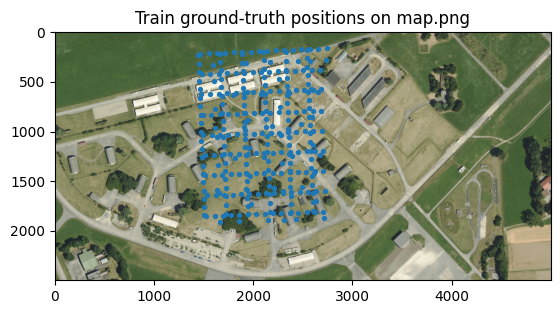

In [5]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def extract_id(filename: str) -> int:
    # Assumption: filenames contain an integer id, e.g. "12.png" or "img_12.jpg"
    m = re.search(r"(\d+)", os.path.basename(filename))
    if not m:
        raise ValueError(f"Could not extract id from filename: {filename}")
    return int(m.group(1))

# Paths
map_path = "/home/rupert/projects/gnss-denied-localization/data/map.png"
train_pos_path = "/home/rupert/projects/gnss-denied-localization/data/train_data/train_pos.csv"

# Load
pos_df = pd.read_csv(train_pos_path)  # expect columns like: id, x_pixel, y_pixel (or similar)
print(pos_df.head(), pos_df.columns)

# Load map
map_img = mpimg.imread(map_path)

# Plot
plt.figure()
plt.imshow(map_img)
plt.scatter(pos_df["x_pixel"], pos_df["y_pixel"], s=8)
plt.title("Train ground-truth positions on map.png")
plt.show()


In [7]:
import os
import pandas as pd
import re

def extract_id_from_name(name: str) -> int:
    m = re.search(r"(\d+)", os.path.basename(name))
    if not m:
        raise ValueError(f"No numeric id in filename: {name}")
    return int(m.group(1))

test_images_dir = "/home/rupert/projects/gnss-denied-localization/data/test_data/test_images"

# Example: dummy predictor (replace with your model)
def predict_xy_for_image(image_path: str) -> tuple[float, float]:
    # TODO: implement
    return 0.0, 0.0

rows = []
for fn in sorted(os.listdir(test_images_dir)):
    if not fn.lower().endswith((".png", ".jpg", ".jpeg")):
        continue
    img_path = os.path.join(test_images_dir, fn)
    img_id = extract_id_from_name(fn)
    x, y = predict_xy_for_image(img_path)
    rows.append({"id": img_id, "x_pixel": float(x), "y_pixel": float(y)})

sub_df = pd.DataFrame(rows).sort_values("id")
sub_df.to_csv("submission.csv", index=False)
print(sub_df.head())


   id  x_pixel  y_pixel
0   1      0.0      0.0
1   2      0.0      0.0
2   3      0.0      0.0
3   4      0.0      0.0
4   5      0.0      0.0


In [8]:
#!/usr/bin/env python3
"""
Naive GNSS-denied localization baseline (template matching).

Key fixes vs. your snippet:
- cv2.matchTemplate expects (image, template) -> (ortho_map, query_template)
- Robust handling of None reads / empty folders
- Clean preprocessing (optional edges) to stabilize matching
- Writes a submission-style CSV: id,x_pixel,y_pixel
"""

from __future__ import annotations

import csv
from dataclasses import dataclass
from pathlib import Path
from typing import Iterable, Optional, Tuple

import cv2
import numpy as np


# ----------------------------
# Config
# ----------------------------
@dataclass(frozen=True)
class Config:
    data_path: Path = Path("/home/rupert/projects/gnss-denied-localization/data")
    map_file: str = "map.png"
    test_images_dir: Path = Path("test_data/test_images")
    out_csv: Path = Path("predictions.csv")

    # search space
    scales: Tuple[float, ...] = (0.05, 0.075, 0.10, 0.15, 0.20)
    rotations_deg: Tuple[int, ...] = (0, 90, 180, 270)

    # matching
    method: int = cv2.TM_CCOEFF_NORMED  # change if you want
    use_edges: bool = True             # tends to be more robust than raw grayscale


# ----------------------------
# Utilities
# ----------------------------
def read_gray(path: Path) -> np.ndarray:
    img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Could not read image: {path}")
    return img


def preprocess(img_gray: np.ndarray, use_edges: bool) -> np.ndarray:
    if not use_edges:
        # mild normalization helps a bit
        img = cv2.GaussianBlur(img_gray, (3, 3), 0)
        return img

    # edge-based matching is often less sensitive to illumination/texture shifts
    img = cv2.GaussianBlur(img_gray, (3, 3), 0)
    edges = cv2.Canny(img, threshold1=50, threshold2=150, L2gradient=True)
    return edges


def rotate_90n(img: np.ndarray, deg: int) -> np.ndarray:
    deg = deg % 360
    if deg == 0:
        return img
    if deg == 90:
        return cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    if deg == 180:
        return cv2.rotate(img, cv2.ROTATE_180)
    if deg == 270:
        return cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    raise ValueError(f"Unsupported rotation: {deg}")


def iter_test_images(folder: Path) -> Iterable[Path]:
    if not folder.exists():
        raise FileNotFoundError(f"Test images folder does not exist: {folder}")
    paths = sorted([p for p in folder.iterdir() if p.is_file()])
    if not paths:
        raise RuntimeError(f"No files found in: {folder}")
    return paths


def score_from_minmax(method: int, min_val: float, max_val: float) -> float:
    # for SQDIFF, smaller is better; convert so "larger is better" consistently
    if method in (cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED):
        return -float(min_val)
    return float(max_val)


def best_loc_from_minmax(method: int, min_loc, max_loc):
    if method in (cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED):
        return min_loc
    return max_loc


# ----------------------------
# Core matching
# ----------------------------
def find_location_template(
    query_gray: np.ndarray,
    ortho_gray: np.ndarray,
    cfg: Config,
) -> Tuple[Optional[Tuple[int, int]], float]:
    """
    Returns:
      (center_x, center_y) in ortho/map pixels, and best score
    """
    ortho = preprocess(ortho_gray, cfg.use_edges)
    query_base = preprocess(query_gray, cfg.use_edges)

    best_score = -np.inf
    best_center: Optional[Tuple[int, int]] = None

    H, W = ortho.shape[:2]

    for scale in cfg.scales:
        # scale query (template)
        new_w = max(1, int(query_base.shape[1] * scale))
        new_h = max(1, int(query_base.shape[0] * scale))
        templ_scaled = cv2.resize(query_base, (new_w, new_h), interpolation=cv2.INTER_AREA)

        # skip if template larger than map
        if templ_scaled.shape[0] > H or templ_scaled.shape[1] > W:
            continue

        for deg in cfg.rotations_deg:
            templ = rotate_90n(templ_scaled, deg)

            # after rotation, size may swap; re-check
            th, tw = templ.shape[:2]
            if th > H or tw > W:
                continue

            # IMPORTANT: matchTemplate(image, template)
            res = cv2.matchTemplate(ortho, templ, cfg.method)
            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

            score = score_from_minmax(cfg.method, min_val, max_val)
            top_left = best_loc_from_minmax(cfg.method, min_loc, max_loc)

            if score > best_score:
                best_score = score
                cx = int(top_left[0] + tw // 2)
                cy = int(top_left[1] + th // 2)
                best_center = (cx, cy)

    return best_center, float(best_score)


# ----------------------------
# Main
# ----------------------------
def main() -> None:
    cfg = Config()

    map_path = cfg.data_path / cfg.map_file
    test_dir = cfg.data_path / cfg.test_images_dir
    out_path = cfg.data_path / cfg.out_csv

    ortho_gray = read_gray(map_path)

    image_paths = list(iter_test_images(test_dir))

    rows = []
    for img_path in image_paths:
        # expects filenames like "0.png", "1.png", ...
        try:
            img_id = int(img_path.stem)
        except ValueError:
            # skip non-numeric stems
            continue

        query_gray = read_gray(img_path)
        center, score = find_location_template(query_gray, ortho_gray, cfg)

        if center is None:
            # fallback if nothing matched (should be rare unless scales all invalid)
            center = (0, 0)

        rows.append((img_id, center[0], center[1], score))

    # sort by id for clean output
    rows.sort(key=lambda x: x[0])

    # write CSV (id,x_pixel,y_pixel) + optional score column for debugging
    with open(out_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["id", "x_pixel", "y_pixel", "score"])
        for img_id, x, y, score in rows:
            writer.writerow([img_id, x, y, f"{score:.6f}"])

    # also print submission-style lines (without score) if you want
    print(f"{'id':>5s},{'x_pixel':>9s},{'y_pixel':>9s}")
    for img_id, x, y, _ in rows:
        print(f"{img_id:5d},{x:9d},{y:9d}")

    print(f"\nWrote: {out_path}")


if __name__ == "__main__":
    main()


   id,  x_pixel,  y_pixel
    1,     3857,      803
    2,     1663,     1387
    3,      699,     1850
    4,      264,      214
    5,      214,     2169
    6,      693,     1926
    7,      263,      200
    8,     1542,     1241
    9,     1573,     1272
   10,      721,     1864
   11,      328,      309
   12,      298,      269
   42,     1148,      508
   43,     1669,     1394
   44,     4781,      896
   53,      728,     1891
   54,     3592,     1226
   55,      684,     1832
   56,     1522,     1226
   65,     4793,      988
   66,      672,     1826
   67,     1736,     1400
   68,     3846,      840
 2468,      679,     1839
 2469,     4783,     1028
 2470,     3955,     1806
 2471,     3587,      903
 2472,      178,      303
 2473,      233,      349
 2474,     1692,     1365
 2475,     4692,      831
 2476,     1542,     1284
 2477,      737,     1955
 2478,     1667,     1281
 2479,      755,     1918
 2480,      694,     1915
 2481,      711,     1848
 2482,      